In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import matplotlib
import winsound
import os
import scipy
import copy
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.cross_validation import train_test_split, LeaveOneOut, StratifiedKFold, KFold
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor, \
    GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectPercentile, f_classif, RFE, RFECV
import sklearn.linear_model as sk_lm
from lib_helper import *
from lib_plotting import *
from lib_recres import *

C:\Users\Artem\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Set plot parameters
default_figsize = (12, 9)
scale_pic = 1.0
my_font = "Times New Roman"#'Times New Roman' #'STIXGeneral'
pylab.rcParams['figure.figsize'] = default_figsize
pylab.rcParams['mathtext.rm'] = my_font
pylab.rcParams['mathtext.it'] = my_font
pylab.rcParams['mathtext.bf'] = my_font
plt.rc('font',**{'family':'serif','serif':[my_font],'size':14})

Load data

In [4]:
# Load metafeatures
df_metafs = pd.read_csv('./1_metafeatures/metafeatures.csv', index_col = 0)
df_metafs.index = df_metafs['dataset']
df_metafs = df_metafs.drop('dataset', axis = 1)

In [5]:
# Add metafeatures in logarithmic scale
for i, col in zip(range(df_metafs.shape[1]), df_metafs.columns):
    #print i, col, df_metafs[col].max(), df_metafs[col].min()
    if df_metafs[col].min() > 0:
        df_metafs[col + '_log1p'] = np.log1p(df_metafs[col])

In [6]:
# Define useful constants
available_metrics = ['prc_auc', 'roc_auc']
available_classifiers = ['logreg_l1', 'logreg_l2', 'knn', 'dtree']
available_resamplers = ['bootstrap', 'rus', 'smote1', 'smote3', 'smote5', 'smote7']
available_multipliers = [1.25 + i * 0.25 for i in range(4*9)]
ds_real = [ds for ds in df_metafs.index if 'art' not in ds]
ds_art = [ds for ds in df_metafs.index if 'art' in ds]
ser_defmult = ((1 / df_metafs['min_maj_ratio'] * 4).round() / 4.0).combine(pd.Series(10, index=df_metafs.index), min)

In [7]:
# Load scores data frames which were prepared by data-preprocessing.ipynb
# key: metric (e.g. prc_auc_dtree), value: dataframe
# _nores - no resampling; _res - with resampling; _agg - aggregations; res_ir1 - resampling with imbalance ratio=1.0
dict_scores_nores, dict_scores_res, dict_scores_agg, dict_scores_res_ir1 = {}, {}, {}, {}
for clf, met in itertools.product(available_classifiers, available_metrics):
    metric = clf + '_' + met
    dict_scores_nores[metric] = pd.read_csv('2_df_scores/df_scores_nores_' + metric + '.csv', index_col=0)
    dict_scores_res[metric] = pd.read_csv('2_df_scores/df_scores_res_' + metric + '.csv', index_col=0, header=[0,1,2])
    temp = dict_scores_res[metric].columns._tuples
    temp2 = [[temp[i][0], float(temp[i][1]), temp[i][2]] for i in range(len(temp))]
    dict_scores_res[metric].columns = map(list, zip(*temp2))
    dict_scores_agg[metric] = pd.read_csv('2_df_scores/df_scores_agg_' + metric + '.csv', index_col=0, header=[0,1,2])
    
    df_temp2 = pd.DataFrame(index=df_metafs.index, columns = available_resamplers)
    for i in df_temp2.index:
        df_temp2.loc[i] = dict_scores_res[metric].xs(ser_defmult[i], level=1, axis=1).xs('mean', level=1, axis=1).loc[i]
    df_temp2.columns = [col + '_IR=1' for col in df_temp2.columns]
    dict_scores_res_ir1[metric] = df_temp2

Learn and validate recommendation systems

In [8]:
print available_classifiers
print df_metafs.columns.tolist()

features1 = ['n_objects', 'n_features', 'objects_features_ratio', 'min_maj_ratio', 
             'dist_class_centers', 'max_major_cov_abs_eigenvalue', 'max_minor_cov_abs_eigenvalue', 
             'min_major_cov_abs_eigenvalue', 
             'min_minor_cov_abs_eigenvalue', 'min_major_skewness', 'min_minor_skewness', 'max_major_skewness', 
             'max_minor_skewness', 'min_major_skewness_pvalue', 
             'min_minor_skewness_pvalue', 'max_major_skewness_pvalue', 'max_minor_skewness_pvalue', 
             'min_major_skewness_stat', 'min_minor_skewness_stat', 
             'max_major_skewness_stat', 'max_minor_skewness_stat', 'min_major_kurtosis', 'min_minor_kurtosis', 
             'max_major_kurtosis', 'max_minor_kurtosis', 
             'min_major_kurtosis_pvalue', 'min_minor_kurtosis_pvalue', 'max_major_kurtosis_pvalue', 
             'max_minor_kurtosis_pvalue', 'min_major_kurtosis_stat', 
             'min_minor_kurtosis_stat', 'max_major_kurtosis_stat', 'max_minor_kurtosis_stat', 
             'n_objects_log1p', 'n_features_log1p', 'objects_features_ratio_log1p', 
             'min_maj_ratio_log1p', 'dist_class_centers_log1p', 'max_major_cov_abs_eigenvalue_log1p', 
             'max_minor_cov_abs_eigenvalue_log1p', 
             'max_major_skewness_pvalue_log1p', 'max_minor_skewness_pvalue_log1p', 'max_major_kurtosis_pvalue_log1p', 
             'max_minor_kurtosis_pvalue_log1p']

features2 = ['n_objects', 'n_features', 'objects_features_ratio', 'min_maj_ratio', 'dist_class_centers', 
             'max_minor_cov_abs_eigenvalue']

features3 = ['min_maj_ratio', 'dist_class_centers', 'max_minor_cov_abs_eigenvalue', 
             'max_minor_kurtosis', 'max_minor_skewness', 'min_minor_kurtosis', 'min_minor_skewness',
            'min_major_cov_abs_eigenvalue', 'min_major_kurtosis', 'max_major_skewness_pvalue']

['logreg_l1', 'logreg_l2', 'knn', 'dtree']
['n_objects', 'n_features', 'objects_features_ratio', 'min_maj_ratio', 'dist_class_centers', 'mean_dist_between_classes_0.0-0.3', 'mean_dist_between_classes_0.3-0.7', 'mean_dist_between_classes_0.7-1.0', 'max_major_cov_abs_eigenvalue', 'max_minor_cov_abs_eigenvalue', 'min_major_cov_abs_eigenvalue', 'min_minor_cov_abs_eigenvalue', 'min_major_skewness', 'min_minor_skewness', 'max_major_skewness', 'max_minor_skewness', 'min_major_skewness_pvalue', 'min_minor_skewness_pvalue', 'max_major_skewness_pvalue', 'max_minor_skewness_pvalue', 'min_major_skewness_stat', 'min_minor_skewness_stat', 'max_major_skewness_stat', 'max_minor_skewness_stat', 'min_major_kurtosis', 'min_minor_kurtosis', 'max_major_kurtosis', 'max_minor_kurtosis', 'min_major_kurtosis_pvalue', 'min_minor_kurtosis_pvalue', 'max_major_kurtosis_pvalue', 'max_minor_kurtosis_pvalue', 'min_major_kurtosis_stat', 'min_minor_kurtosis_stat', 'max_major_kurtosis_stat', 'max_minor_kurtosis_stat', '

In [9]:
dict_exp_rec = {}
dict_exp_rec_scores = {}

Recommendation system #1: learning & cross-validation

In [17]:
# RecommendatorRes1 cross-validation. Art data. Metric: 'dtree_prc_auc'
name = 'rec1_art_data_cv'
metric = 'dtree_prc_auc'
ds = ds_art
y_col = 'pval_winmax'
features = features2#['min_maj_ratio_log1p', 'dist_class_centers_log1p']
base_clf = AdaBoostClassifier(n_estimators = 10)

recres = RecommendatorRes1(threshold=0.05)
rec, rec_scores = recres.assess_cv(
    df_metafs.loc[ds, features], 
    dict_scores_res[metric].xs(y_col, axis=1, level=2).loc[ds],
    dict_scores_res[metric].xs('mean', axis=1, level=2).loc[ds], 
    dict_scores_nores[metric]['mean'].loc[ds],
    n_folds = 10, base_clf=base_clf)
dict_exp_rec[(name, metric)], dict_exp_rec_scores[(name, metric)] = rec, rec_scores

In [18]:
#RecommendatorRes1 cross-validation. Real data. Metric: 'dtree_prc_auc'
name = 'rec1_real_data_cv'
metric = 'dtree_prc_auc'
ds = ds_real
y_col = 'pval_winmax'
features = ['min_maj_ratio_log1p', 'dist_class_centers_log1p', 'n_objects', 'min_major_cov_abs_eigenvalue', 
            'max_minor_kurtosis_pvalue']
base_clf = AdaBoostClassifier(n_estimators = 10)

recres = RecommendatorRes1(threshold=0.05)
rec, rec_scores = recres.assess_cv(
    df_metafs.loc[ds, features], 
    dict_scores_res[metric].xs(y_col, axis=1, level=2).loc[ds],
    dict_scores_res[metric].xs('mean', axis=1, level=2).loc[ds], 
    dict_scores_nores[metric]['mean'].loc[ds],
    n_folds = 10, base_clf=base_clf)
dict_exp_rec[(name, metric)], dict_exp_rec_scores[(name, metric)] = rec, rec_scores

In [19]:
# RecommendatorRes1 cross-validation. Art data. Metric: 'knn_prc_auc'
name = 'rec1_art_data_cv'
metric = 'knn_prc_auc'
ds = ds_art
y_col = 'pval_winmax'
features = features1
base_clf = AdaBoostClassifier(n_estimators = 10)

recres = RecommendatorRes1(threshold=0.05)
rec, rec_scores = recres.assess_cv(
    df_metafs.loc[ds, features], 
    dict_scores_res[metric].xs(y_col, axis=1, level=2).loc[ds],
    dict_scores_res[metric].xs('mean', axis=1, level=2).loc[ds], 
    dict_scores_nores[metric]['mean'].loc[ds],
    n_folds = 10, base_clf=base_clf)
dict_exp_rec[(name, metric)], dict_exp_rec_scores[(name, metric)] = rec, rec_scores

In [20]:
# RecommendatorRes1 cross-validation. Real data. Metric: 'knn_prc_auc'
name = 'rec1_real_data_cv'
metric = 'knn_prc_auc'
ds = ds_real
y_col = 'pval_winmax'
features = features1
base_clf = AdaBoostClassifier(n_estimators = 10)

recres = RecommendatorRes1(threshold=0.05)
rec, rec_scores = recres.assess_cv(
    df_metafs.loc[ds, features], 
    dict_scores_res[metric].xs(y_col, axis=1, level=2).loc[ds],
    dict_scores_res[metric].xs('mean', axis=1, level=2).loc[ds], 
    dict_scores_nores[metric]['mean'].loc[ds],
    n_folds = 10, base_clf=base_clf)
dict_exp_rec[(name, metric)], dict_exp_rec_scores[(name, metric)] = rec, rec_scores

In [21]:
# RecommendatorRes1 cross-validation. Art data. Metric: 'logreg_l1_prc_auc'
name = 'rec1_art_data_cv'
metric = 'logreg_l1_prc_auc'
ds = ds_art
y_col = 'pval_winmax'
features = features3
base_clf = LogisticRegression(penalty='l1')

recres = RecommendatorRes1(threshold=0.05)
rec, rec_scores = recres.assess_cv(
    df_metafs.loc[ds, features], 
    dict_scores_res[metric].xs(y_col, axis=1, level=2).loc[ds],
    dict_scores_res[metric].xs('mean', axis=1, level=2).loc[ds], 
    dict_scores_nores[metric]['mean'].loc[ds],
    n_folds = 10, base_clf=base_clf)
dict_exp_rec[(name, metric)], dict_exp_rec_scores[(name, metric)] = rec, rec_scores

In [22]:
# RecommendatorRes1 cross-validation. Real data. Metric: 'logreg_l1_prc_auc'
name = 'rec1_real_data_cv'
metric = 'logreg_l1_prc_auc'
ds = ds_real
y_col = 'pval_winmax'
features = features3
base_clf = LogisticRegression(penalty='l1')

recres = RecommendatorRes1(threshold=0.05)
rec, rec_scores = recres.assess_cv(
    df_metafs.loc[ds, features], 
    dict_scores_res[metric].xs(y_col, axis=1, level=2).loc[ds],
    dict_scores_res[metric].xs('mean', axis=1, level=2).loc[ds], 
    dict_scores_nores[metric]['mean'].loc[ds],
    n_folds = 10, base_clf=base_clf)
dict_exp_rec[(name, metric)], dict_exp_rec_scores[(name, metric)] = rec, rec_scores

Recommendation system #2: learning & cross-validation

In [10]:
# RecommendatorRes2 cross-validation. Art data. Metric: 'dtree_prc_auc'
name = 'rec2_art_data_cv'
metric = 'dtree_prc_auc'
ds = ds_art
y_col = 'pval_winmax'
features = ['min_maj_ratio_log1p', 'dist_class_centers_log1p']
base_clf = AdaBoostClassifier(n_estimators = 10)
base_rgr = AdaBoostRegressor(n_estimators = 10, base_estimator = DecisionTreeRegressor())
recres = RecommendatorRes2(threshold=0.05)

rec, rec_scores = recres.assess_cv(
    df_metafs.loc[ds, features], 
    dict_scores_res[metric].xs(y_col, axis=1, level=2).loc[ds],
    dict_scores_res[metric].xs('mean', axis=1, level=2).loc[ds], 
    dict_scores_nores[metric]['mean'].loc[ds],
    n_folds = 10, base_clf=base_clf, base_rgr=base_rgr)
dict_exp_rec[(name, metric)], dict_exp_rec_scores[(name, metric)] = rec, rec_scores

In [11]:
# RecommendatorRes2 cross-validation. Real data. Metric: 'dtree_prc_auc'
name = 'rec2_real_data_cv'
metric = 'dtree_prc_auc'
ds = ds_real
y_col = 'pval_winmax'
features = ['min_maj_ratio_log1p', 'dist_class_centers_log1p']
base_clf = AdaBoostClassifier(n_estimators = 10)
base_rgr = AdaBoostRegressor(n_estimators = 10, base_estimator = DecisionTreeRegressor())
recres = RecommendatorRes2(threshold=0.05)

rec, rec_scores = recres.assess_cv(
    df_metafs.loc[ds, features], 
    dict_scores_res[metric].xs(y_col, axis=1, level=2).loc[ds],
    dict_scores_res[metric].xs('mean', axis=1, level=2).loc[ds], 
    dict_scores_nores[metric]['mean'].loc[ds],
    n_folds = 10, base_clf=base_clf, base_rgr=base_rgr)
dict_exp_rec[(name, metric)], dict_exp_rec_scores[(name, metric)] = rec, rec_scores

In [12]:
# RecommendatorRes2 cross-validation. Art data. Metric: 'knn_prc_auc'
name = 'rec2_art_data_cv'
metric = 'knn_prc_auc'
ds = ds_art
y_col = 'pval_winmax'
features = ['min_maj_ratio_log1p', 'dist_class_centers_log1p']
base_clf = AdaBoostClassifier(n_estimators = 10)
base_rgr = AdaBoostRegressor(n_estimators = 10, base_estimator = DecisionTreeRegressor())
recres = RecommendatorRes2(threshold=0.05)

rec, rec_scores = recres.assess_cv(
    df_metafs.loc[ds, features], 
    dict_scores_res[metric].xs(y_col, axis=1, level=2).loc[ds],
    dict_scores_res[metric].xs('mean', axis=1, level=2).loc[ds], 
    dict_scores_nores[metric]['mean'].loc[ds],
    n_folds = 10, base_clf=base_clf, base_rgr=base_rgr)
dict_exp_rec[(name, metric)], dict_exp_rec_scores[(name, metric)] = rec, rec_scores

In [13]:
# RecommendatorRes2 cross-validation. Real data. Metric: 'knn_prc_auc'
name = 'rec2_real_data_cv'
metric = 'knn_prc_auc'
ds = ds_real
y_col = 'pval_winmax'
features = ['min_maj_ratio_log1p', 'dist_class_centers_log1p']
base_clf = AdaBoostClassifier(n_estimators = 10)
base_rgr = AdaBoostRegressor(n_estimators = 10, base_estimator = DecisionTreeRegressor())
recres = RecommendatorRes2(threshold=0.05)

rec, rec_scores = recres.assess_cv(
    df_metafs.loc[ds, features], 
    dict_scores_res[metric].xs(y_col, axis=1, level=2).loc[ds],
    dict_scores_res[metric].xs('mean', axis=1, level=2).loc[ds], 
    dict_scores_nores[metric]['mean'].loc[ds],
    n_folds = 10, base_clf=base_clf, base_rgr=base_rgr)
dict_exp_rec[(name, metric)], dict_exp_rec_scores[(name, metric)] = rec, rec_scores

In [14]:
# RecommendatorRes2 cross-validation. Art data. Metric: 'logreg_l1_prc_auc'
name = 'rec2_art_data_cv'
metric = 'logreg_l1_prc_auc'
ds = ds_art
y_col = 'pval_winmax'
features = ['min_maj_ratio_log1p', 'dist_class_centers_log1p']
base_clf = AdaBoostClassifier(n_estimators = 10)
base_rgr = AdaBoostRegressor(n_estimators = 10, base_estimator = DecisionTreeRegressor())
recres = RecommendatorRes2(threshold=0.05)

rec, rec_scores = recres.assess_cv(
    df_metafs.loc[ds, features], 
    dict_scores_res[metric].xs(y_col, axis=1, level=2).loc[ds],
    dict_scores_res[metric].xs('mean', axis=1, level=2).loc[ds], 
    dict_scores_nores[metric]['mean'].loc[ds],
    n_folds = 10, base_clf=base_clf, base_rgr=base_rgr)
dict_exp_rec[(name, metric)], dict_exp_rec_scores[(name, metric)] = rec, rec_scores

In [16]:
# RecommendatorRes2 cross-validation. Real data. Metric: 'logreg_l1_prc_auc'
name = 'rec2_real_data_cv'
metric = 'logreg_l1_prc_auc'
ds = ds_real
y_col = 'pval_winmax'
features = ['min_maj_ratio_log1p', 'dist_class_centers_log1p']
base_clf = AdaBoostClassifier(n_estimators = 10)
base_rgr = AdaBoostRegressor(n_estimators = 10, base_estimator = DecisionTreeRegressor())
recres = RecommendatorRes2(threshold=0.05)

rec, rec_scores = recres.assess_cv(
    df_metafs.loc[ds, features], 
    dict_scores_res[metric].xs(y_col, axis=1, level=2).loc[ds],
    dict_scores_res[metric].xs('mean', axis=1, level=2).loc[ds], 
    dict_scores_nores[metric]['mean'].loc[ds],
    n_folds = 10, base_clf=base_clf, base_rgr=base_rgr)
dict_exp_rec[(name, metric)], dict_exp_rec_scores[(name, metric)] = rec, rec_scores

In [23]:
# Save dict_exp_rec_scores
for name_tuple, df in dict_exp_rec_scores.iteritems():
    print name_tuple
    df.to_csv('./3_recsyst_results/' + name_tuple[0] + '---' + name_tuple[1] + '.csv')
    #recsyst1_comparison_graphs

('rec2_real_data_cv', 'knn_prc_auc')
('rec1_art_data_cv', 'dtree_prc_auc')
('rec2_art_data_cv', 'dtree_prc_auc')
('rec2_art_data_cv', 'knn_prc_auc')
('rec1_art_data_cv', 'logreg_l1_prc_auc')
('rec1_art_data_cv', 'knn_prc_auc')
('rec1_real_data_cv', 'logreg_l1_prc_auc')
('rec2_art_data_cv', 'logreg_l1_prc_auc')
('rec2_real_data_cv', 'dtree_prc_auc')
('rec1_real_data_cv', 'knn_prc_auc')
('rec1_real_data_cv', 'dtree_prc_auc')
('rec2_real_data_cv', 'logreg_l1_prc_auc')


Show results

In [26]:
# Load dict_exp_rec_scores
for fname in os.listdir('./3_recsyst_results/'):
    print fname
    df = pd.read_csv('./3_recsyst_results/' + fname, index_col=0)
    name_tuple = tuple(fname[:-4].split('---'))
    dict_exp_rec_scores[name_tuple] = df

rec1_art_data_cv---dtree_prc_auc.csv
rec1_art_data_cv---knn_prc_auc.csv
rec1_art_data_cv---logreg_l1_prc_auc.csv
rec1_real_data_cv---dtree_prc_auc.csv
rec1_real_data_cv---knn_prc_auc.csv
rec1_real_data_cv---logreg_l1_prc_auc.csv
rec2_art_data_cv---dtree_prc_auc.csv
rec2_art_data_cv---knn_prc_auc.csv
rec2_art_data_cv---logreg_l1_prc_auc.csv
rec2_real_data_cv---dtree_prc_auc.csv
rec2_real_data_cv---knn_prc_auc.csv
rec2_real_data_cv---logreg_l1_prc_auc.csv


In [27]:
def get_subplot_exp(ax, rec_scores_list, metric, curve_type='ara', 
                      plot_resamplers=['recsyst', 'nothing', 'bootstrap_IR=1', 'rus_IR=1', 'smote5_IR=1'],
                    title=''):
    if curve_type == 'dolan-more': 
        get_points_func=get_dolanmore_points
    elif curve_type == 'performance-profile':
        get_points_func=get_perfprofile_points
    elif curve_type == 'ara':
        get_points_func=get_ara_points
    
    
    ds = rec_scores_list[0].index.tolist()
    #prepare dataframe with all scores needed for plotting
    df_scores = pd.concat([rec_scores[['quality']] for rec_scores in rec_scores_list], axis=1)
    df_scores.columns = ['recsyst' + str(i+1) for i in range(len(rec_scores_list))]
    df_scores.loc[:,'nothing'] = dict_scores_nores[metric].loc[ds, 'mean']
    df_scores.loc[:,'best'] = pd.concat([
            dict_scores_res[metric].xs('mean', level=2, axis=1).loc[ds].max(axis=1), 
            dict_scores_nores[metric]['mean']], axis=1).loc[ds].max(axis=1)
    df_scores.loc[:,'worst'] = pd.concat([
            dict_scores_res[metric].xs('mean', level=2, axis=1).loc[ds].min(axis=1), 
            dict_scores_nores[metric]['mean']], axis=1).loc[ds].min(axis=1)
    df_temp = dict_scores_res[metric].xs(2.0, level=1, axis=1).xs('mean', level=1, axis=1).loc[ds]
    df_temp.columns = [col + '_m=2.0' for col in df_temp.columns]
    df_scores = pd.concat([df_scores, dict_scores_res_ir1[metric].loc[ds], df_temp], axis=1)
    #print df_scores
    
    df_points = get_points_func(df_scores.loc[ds, plot_resamplers], df_scores.loc[ds])
    #ax.set_xscale('log') #!    
    for res in plot_resamplers:
        ax.plot(df_points.index, df_points[res].values, label=res_names[res], 
             color=line_colors[res], ls=line_styles[res], linewidth=0.8 * scale_pic, dashes=line_dashes[res])
    if len(title) > 0:
        ax.text(0.96, 0.05, title, ha='right', transform=ax.transAxes, fontsize=8)
    ax.tick_params(labelsize=7 * scale_pic, size = 2 * scale_pic)
    
def get_mean_ara_table(clf, met, resamplers, res_names=res_names):
    metric_full = clf + '_' + met

    result = pd.DataFrame(index=[res_names[r] for r in resamplers], columns=['Artificial Data', 'Real Data'])
    for r in resamplers:
        if r == 'recsyst1':
            ara_values = [get_ara_values(
                          dict_exp_rec_scores[(mode, metric_full)]['quality'], metric_full).mean()
                          for mode in ['rec1_art_data_cv', 'rec1_real_data_cv']]
            #q_series_art = dict_exp_rec_scores[('rec1_art_data_cv', metric_full)]['quality']
            #q_series_real = dict_exp_rec_scores[('rec1_real_data_cv', metric_full)]['quality']
        elif r[-5:] == '_IR=1':
            ara_values = [get_ara_values(dict_scores_res_ir1[metric_full][r].loc[ds], metric_full).mean()
                          for ds in [ds_art, ds_real]]
        elif r == 'nothing':
            ara_values = [get_ara_values(dict_scores_nores[metric_full]['mean'].loc[datasets], metric_full).mean()
                          for ds in [ds_art, ds_real]]            
        else:
            #resampling with fixed multiplier
            pass  
        result.loc[res_names[r]] = ara_values
    return result

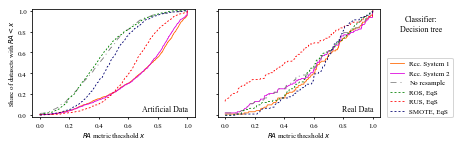

In [32]:
# plot graphs for recommendation system evaluation
clf_to_plot = 'dtree'
met_to_plot = 'prc_auc'
curve_type = 'ara' # 'dolan-more' or 'performance-profile' or 'ara'
#exp_prefix = 'rec2_'
resamplers_to_plot = ['recsyst1', 'recsyst2', 'nothing', 'bootstrap_IR=1', 'rus_IR=1', 'smote5_IR=1']
if curve_type == 'dolan-more': 
    xlabel, ylabel = r'$\beta = Q_{best} / Q$', 'Share of datasets ' + r'$p(\beta)$'
    xlim1 = [1.0, 1.1]
    xlim2 = [1.0, 1.3]
elif curve_type == 'performance-profile':
    xlabel, ylabel = 'Quality threshold ' + r'$\beta$', 'Share of datasets with ' + r'$Q < \beta$'
    xlim1 = [0.0, 1.0]
    xlim2 = [0.0, 1.0]
elif curve_type == 'ara':
    xlabel, ylabel = r'$R\!A$' + ' metric threshold ' + r'$x$', 'Share of datasets with ' + r'$R\!A < x$'
    xlim1 = [0.0, 1.0]
    xlim2 = [0.0, 1.0]  

metric_full = clf_to_plot + '_' + met_to_plot   
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 2))

get_subplot_exp(ax1, [dict_exp_rec_scores[(prefix+'art_data_cv', metric_full)] for prefix in ['rec1_', 'rec2_']], metric_full, 
                 plot_resamplers=resamplers_to_plot, curve_type=curve_type, title='Artificial Data')
get_subplot_exp(ax2, [dict_exp_rec_scores[(prefix+'real_data_cv', metric_full)] for prefix in ['rec1_', 'rec2_']], metric_full, 
                 plot_resamplers=resamplers_to_plot, curve_type=curve_type, title='Real Data')

box1 = ax1.get_position()
box2 = ax2.get_position()
ax1.set_position([box1.x0, box1.y0, box1.width*0.8, box1.height])
ax2.set_position([box1.x0 + box1.width*0.8+0.04, box2.y0, box2.width*0.8, box2.height])
ax2.legend(bbox_to_anchor = (1.02, -0.03), loc='lower left', fontsize=7 * scale_pic)

fig.text(0.8, 0.83, 'Classifier:\n' + clf_names[clf_to_plot], ha='center', va = 'top', fontsize=8)
ax1.set_xlabel(xlabel, fontsize=7 * scale_pic, va='top', labelpad=2)
ax2.set_xlabel(xlabel, fontsize=7 * scale_pic, va='top', labelpad=2)
ax1.set_ylabel(ylabel, fontsize=7 * scale_pic, labelpad=2)
plt.ylim([-0.02, 1.02])

#plt.show()
plt.savefig('./4_graphs-tables-etc/'+ 'both_recsyst_' + curve_type + '_'+clf_to_plot+'_'+met_to_plot+ \
            str(resamplers_to_plot).replace('[', '(').replace(']', ')').replace("'", '').replace(', ', ',')+'.pdf',
            bbox_inches='tight', pad_inches=0.02, dpi=900)